This is an scRNA-seq analysis pipeline for the scRNA-seq bacterial data. We begin by preprocessing the data.

In [1]:
# Import custom library
from utils.pipeline import expandedStats, preprocessing

In [2]:
# Imports
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csr_matrix as densify
import statsmodels.api as sm

%matplotlib inline

# scanpy settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.0.dev100+g41a47480 anndata==0.7.6 umap==0.5.1 numpy==1.17.0 scipy==1.5.2 pandas==1.1.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.9.6 louvain==0.7.0 pynndescent==0.5.2


In [158]:
# Results file we write analysis results to
results_file = 'write/scRNAbac.h5ad'

In [3]:
# Read in the counts matrices into an AnnData object

# First we load in the marker genes
gene_df = pd.read_csv('C:/Users/test/Documents/Smillie/scRNA-seq bacteria/GCF_000694555.gene_map.txt', delimiter="\t")
# Then we want to rename the IDs to the appropriate gene
def returnGeneForId(df, id_val):
    # df = dataframe containing the gene info
    # id_val = the value of the id
    result = df.isin([id_val])
    row = list(result['id'][result['id'] == True].index)
    return df.iloc[row]['gene'].to_string().split()[1]

## NOTE: input your own directory below
x = sc.read_mtx(filename='C:/Users/test/Documents/Smillie/proc/all.matrix.mtx').X.T
adata = sc.AnnData(X=x)
barcodes = features = []
barcodes = [line.rstrip() for line in open('C:/Users/test/Documents/Smillie/proc/all.barcodes.tsv')]
features = [line.rstrip() for line in open('C:/Users/test/Documents/Smillie/proc/all.features.tsv')]
adata.obs_names = barcodes
adata.var_names = [returnGeneForId(gene_df, feature) for feature in features]
adata.var_names_make_unique()

In [4]:
# Estimate the operon structure here
# We say that if the distance between genes is less than 100nt, they're in the same operon

distances = gene_df.beg - np.concatenate(([0], gene_df.end[0:len(gene_df.end)-1]))

# Group genes
operons = np.cumsum([distances > 100])
gene_op_dict = {'operons': operons, 'genes': gene_df.gene, }
df = pd.DataFrame(gene_op_dict)
print(df)

      operons genes
0           0   NaN
1           0   NaN
2           1   NaN
3           2   NaN
4           2   NaN
...       ...   ...
4792     1859  creC
4793     1859  creD
4794     1859  arcA
4795     1859   NaN
4796     1860   NaN

[4797 rows x 2 columns]


# Preprocessing

Now that we've read in the files, we begin the preprocessing steps. This involves:
1. Basic filtering - note that this is made difficult since the data is sparse
2. Computing quality control metrics - we should see no mitochondrial genes since bacteria don't have mitochondria
3. Normalize the library
4. Logarithmize the data
5. Filtering based on highly variable genes - this is challenging since there aren't that many genes with high variance

normalizing counts per cell
    finished (0:00:00)


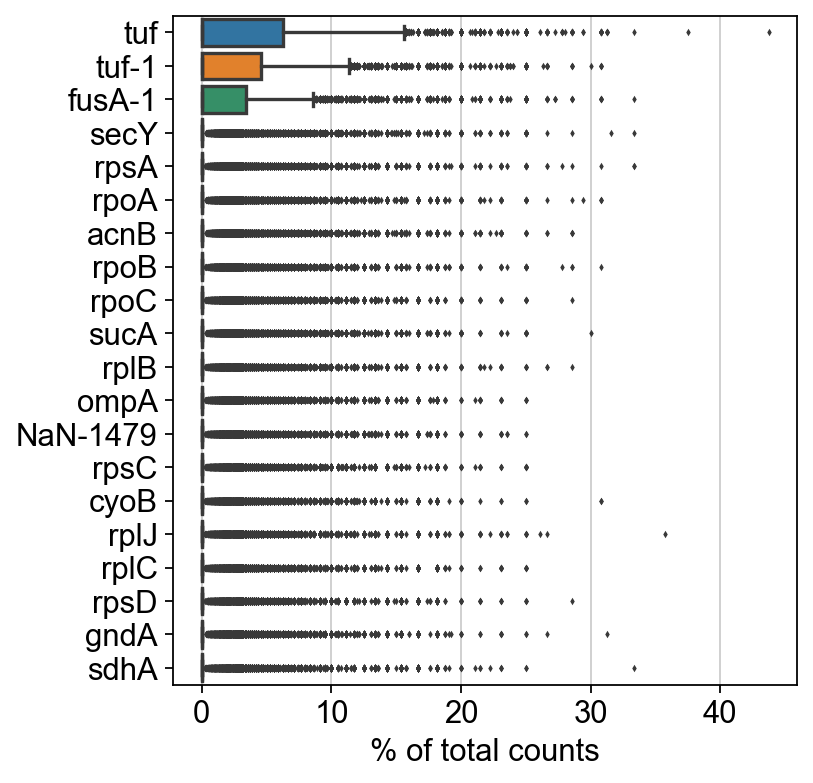

(array([8.3053e+04, 3.6435e+04, 1.1878e+04, 5.0460e+03, 2.8870e+03,
        1.4210e+03, 9.9800e+02, 6.7400e+02, 4.6100e+02, 3.6200e+02,
        2.6600e+02, 2.1700e+02, 2.2400e+02, 1.9300e+02, 1.7100e+02,
        1.1800e+02, 9.8000e+01, 6.8000e+01, 3.3000e+01, 4.3000e+01,
        1.8000e+01, 2.1000e+01, 1.3000e+01, 1.5000e+01, 1.0000e+01,
        9.0000e+00, 7.0000e+00, 6.0000e+00, 1.1000e+01, 7.0000e+00,
        3.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00, 3.0000e+00,
        3.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        5.0000e+00, 5.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

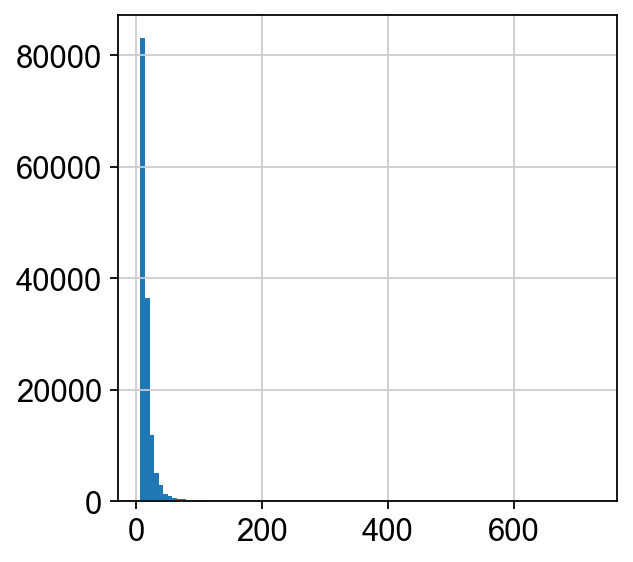

In [4]:
sc.pl.highest_expr_genes(adata, n_top=20)
cell_counts = np.sum(adata.X, axis=1)
gene_counts = np.sum(adata.X, axis=0).T
plt.hist(cell_counts, bins=100)

We create a violin plot of some of the computed quality measures. As expected, we see a value of 0 for mitochondrial genes in terms of percentage.

In [5]:
# Complete entire preprocessing step
val = preprocessing(adata)
adata = val[0]
bdata = val[1]

filtered out 141592 cells that have less than 50 genes expressed
filtered out 949 genes that are detected in less than 4 cells
finished filtering
finished quality control
normalizing counts per cell
    finished (0:00:00)
Performed log normalization
finished normalization
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Identified 2528 highly variable genes
finished filtering based on highly variable genes
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:03)
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)
finished regressing and scaling values


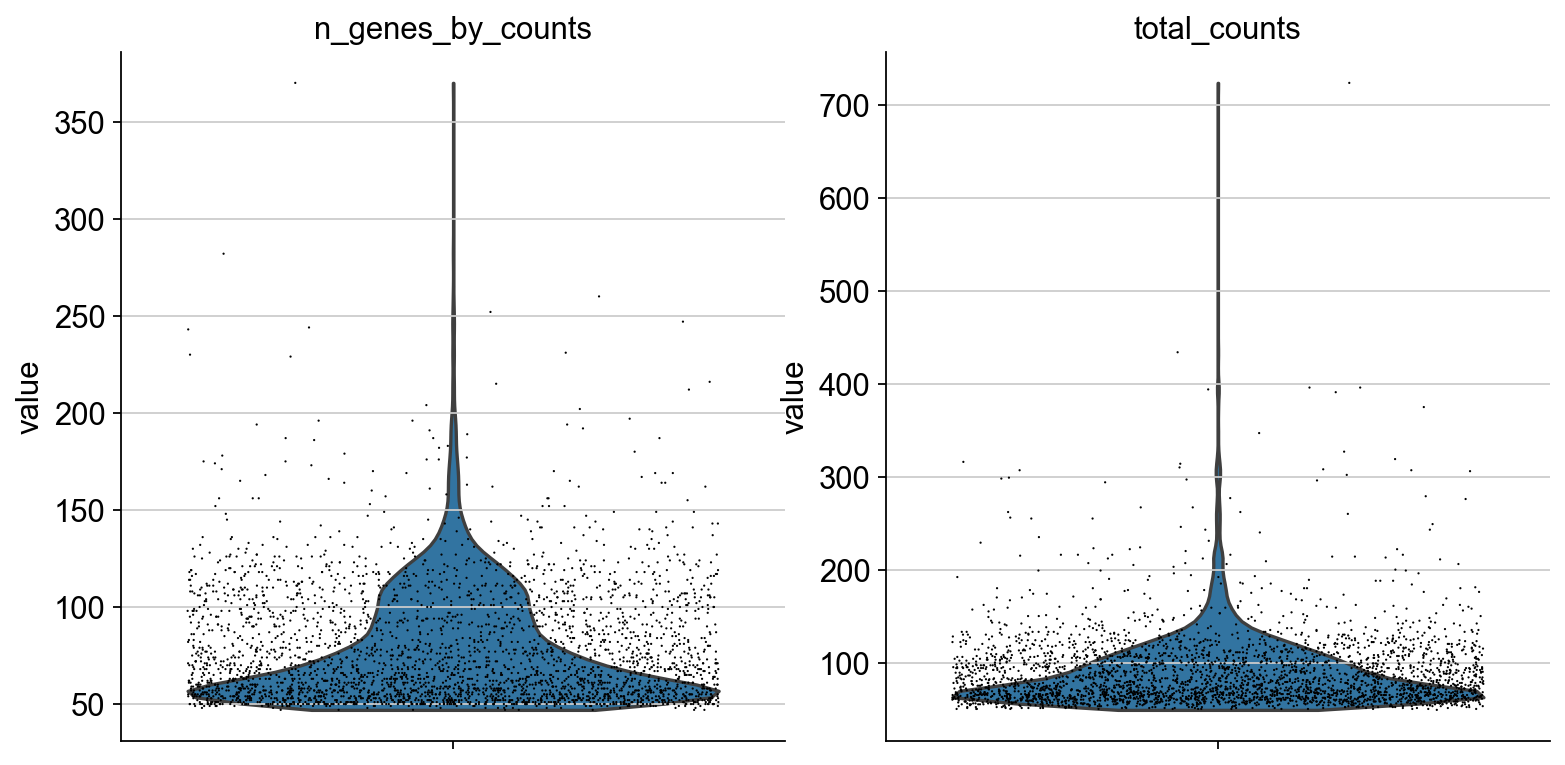

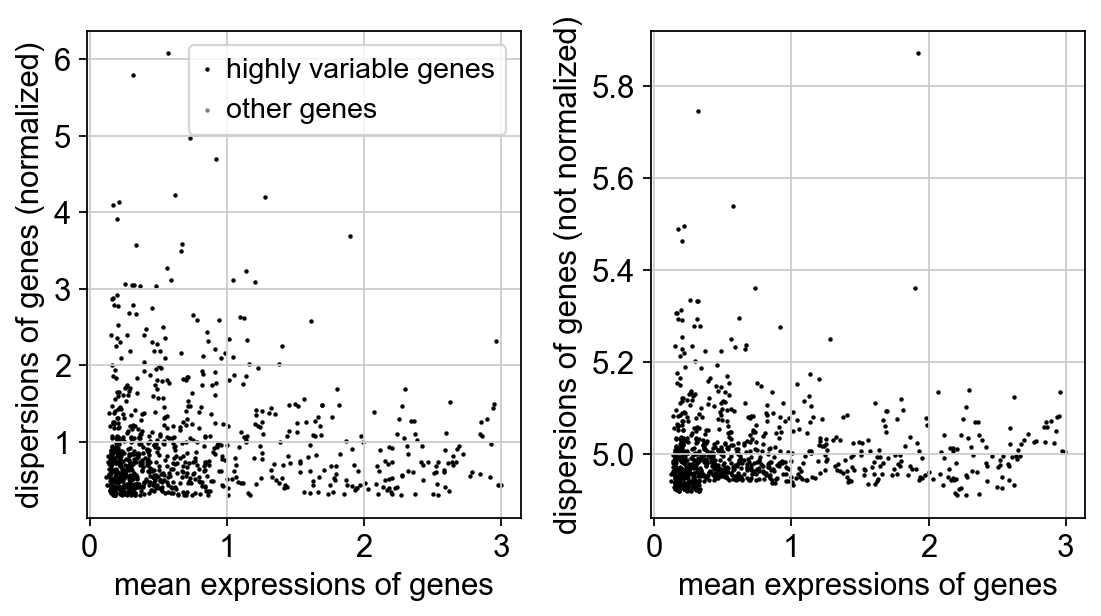

In [6]:
# Plotting suite

# Violin plot first
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
            jitter=0.4, multi_panel=True)
# Highly variable genes
sc.pl.highly_variable_genes(adata)

# Principal Component Analysis

In [7]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


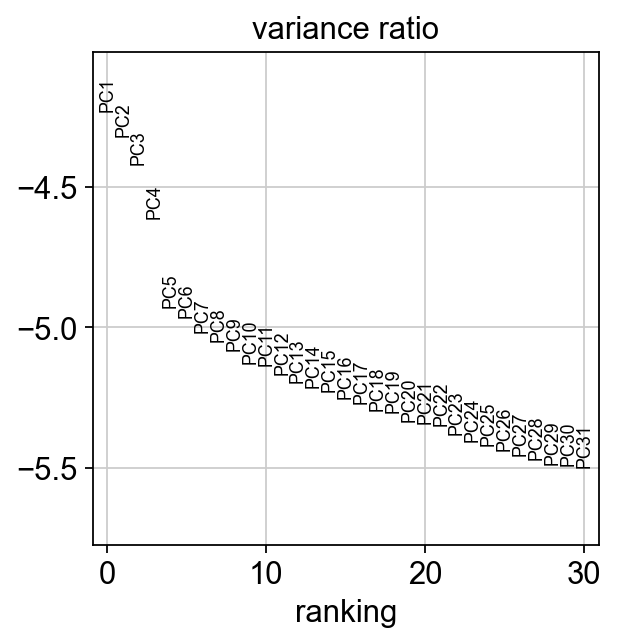

In [8]:
# Inspect contribution of individual PCs to data
sc.pl.pca_variance_ratio(adata, log=True)

# Computing and embedding the neighborhood graph

In [9]:
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=10)
sc.tl.umap(adata)
# sc.pl.umap(adata, color='cds-WP_004174069.1')

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


# Clustering the neighborhood graph

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


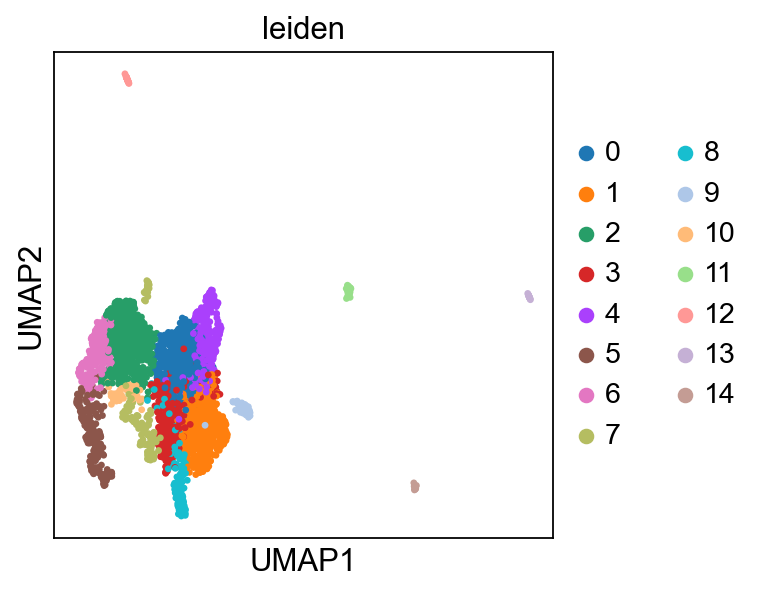

In [10]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

# Finding the Marker Genes
1. Compute the marker genes
2. Compute the additional statistics
3. If logistic, compute the p_vals
4. For each cluster, retrieve a list of qualifying genes

In [11]:
# Detail parameters of interest
method='logreg'
num_markers = 15

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:01)


C:\Users\test\anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


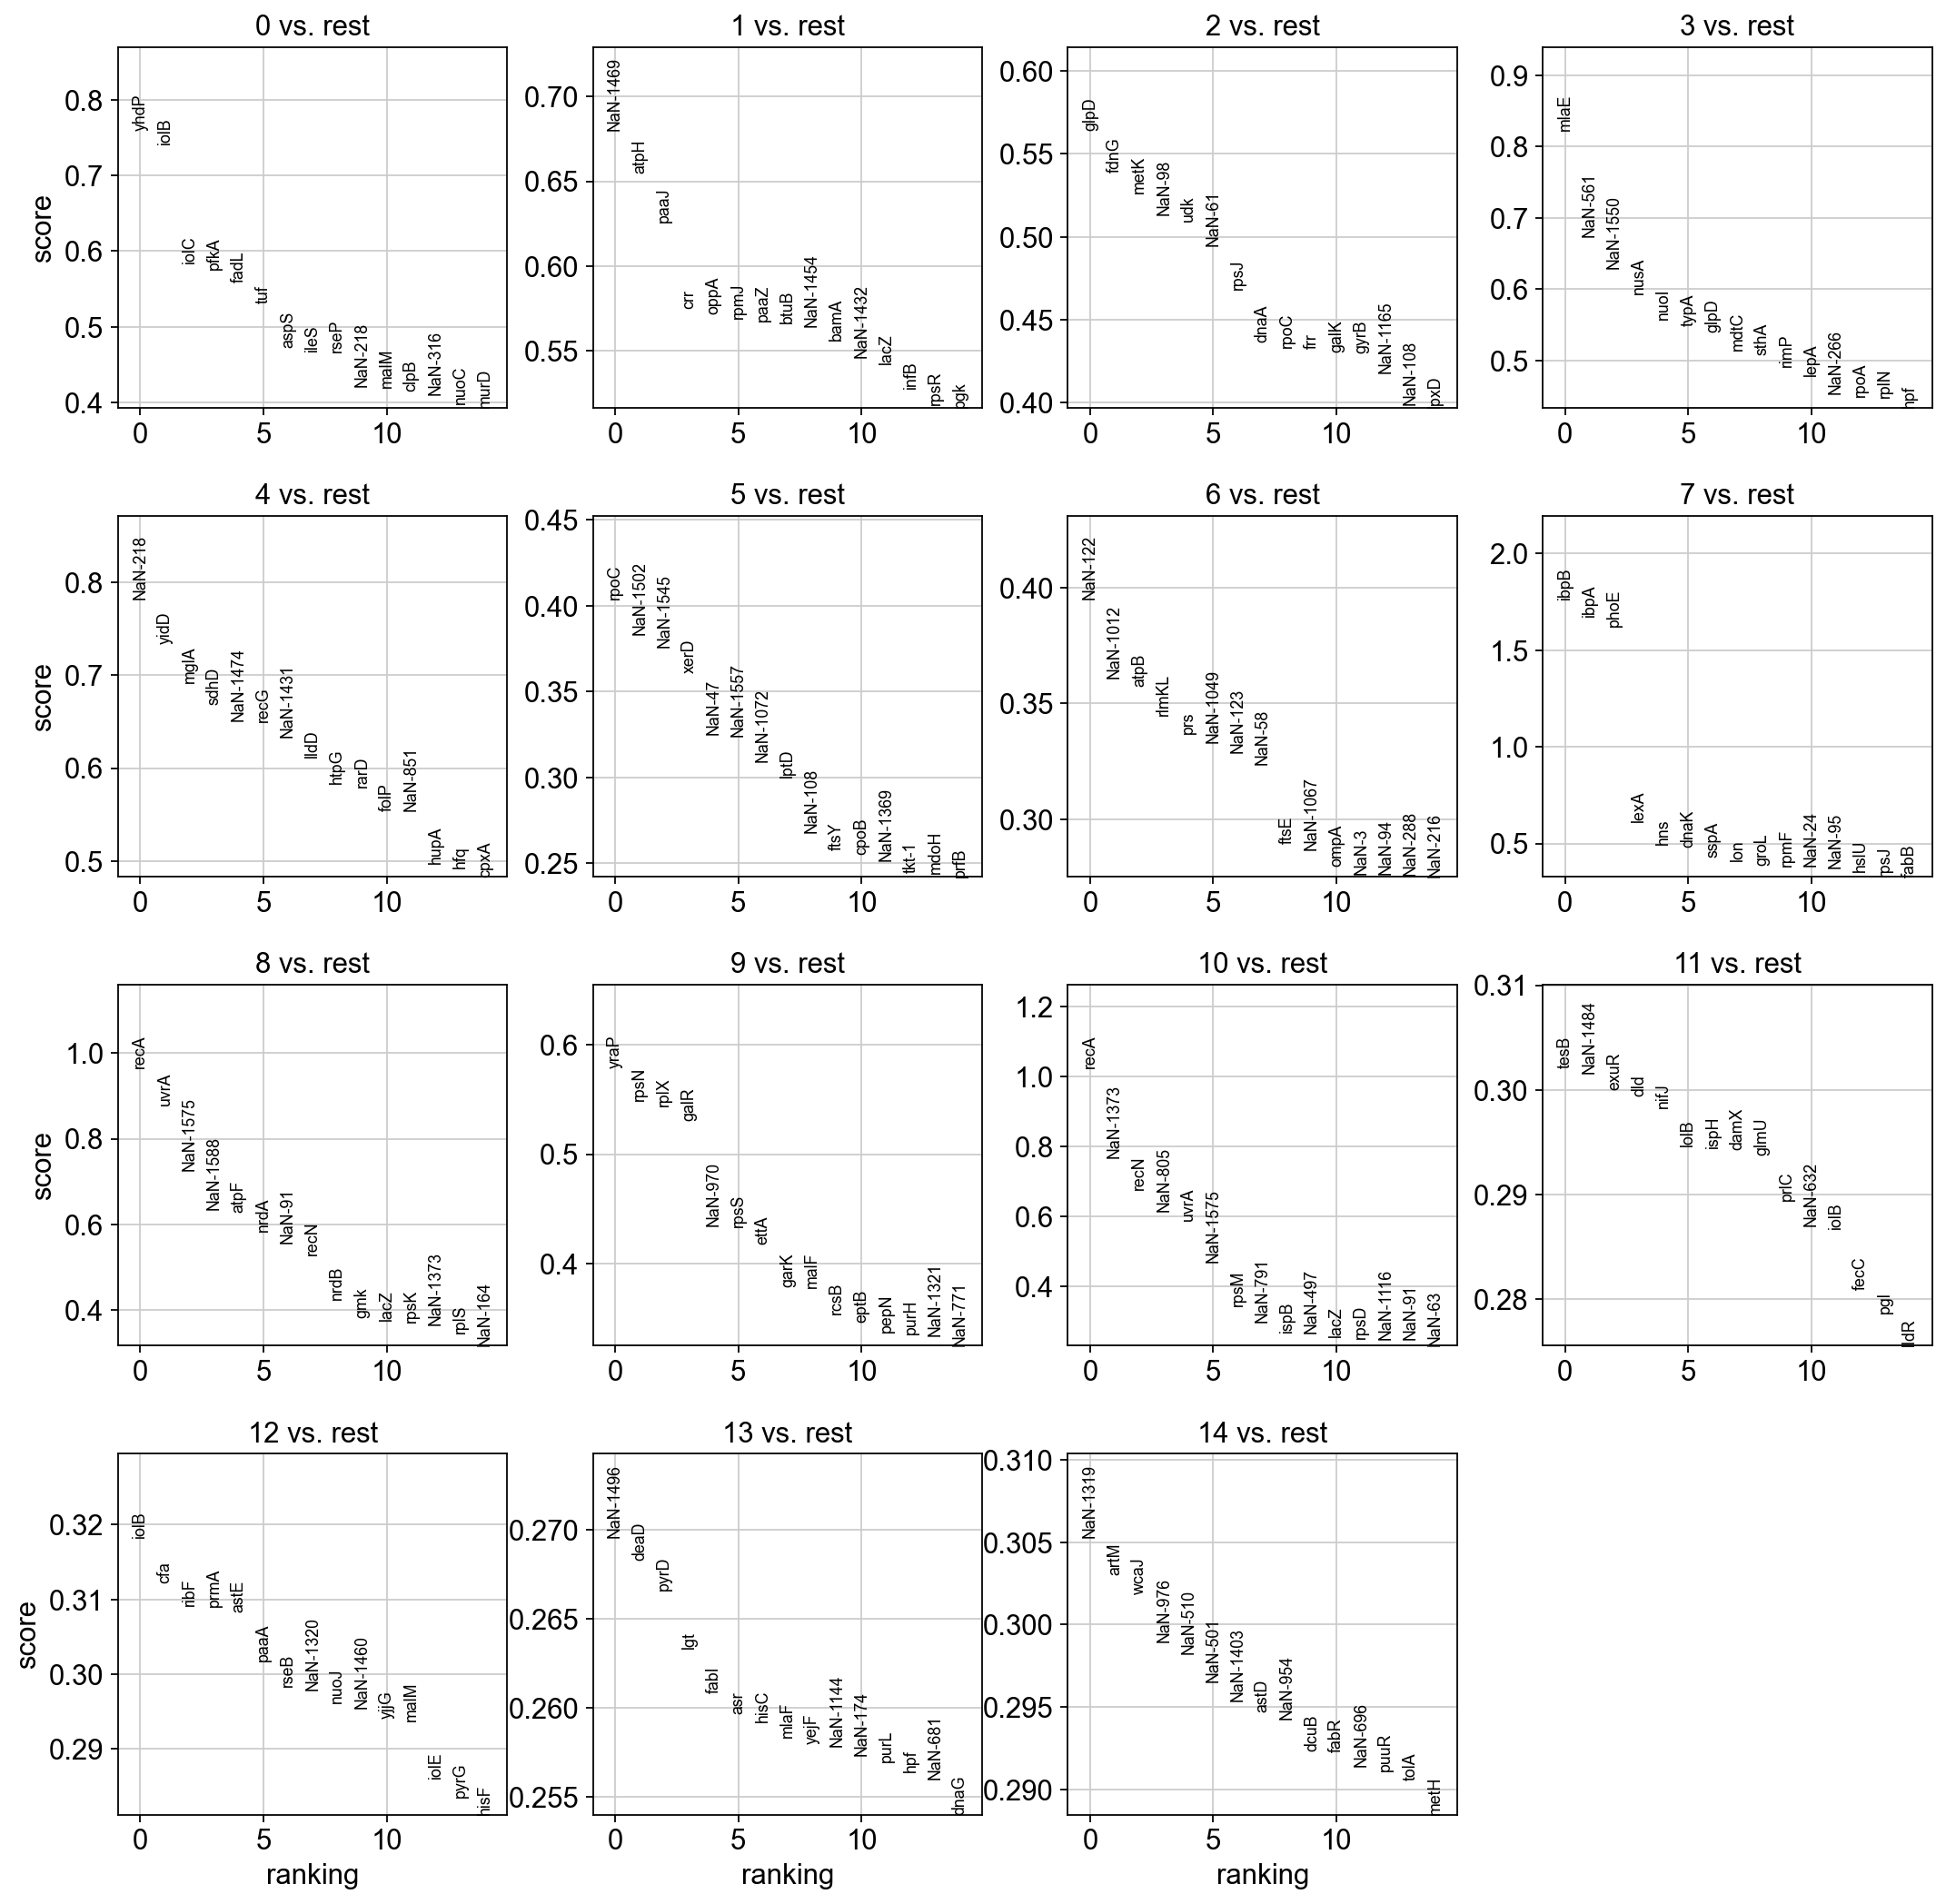

In [12]:
# Compute the marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method=method)
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

In [13]:
# Compute the additional statistics
adata = expandedStats(adata)

In [14]:
num_genes = len(bdata.var.n_cells)
n = len(adata.uns['rank_genes_groups']['scores'])
m = len(adata.uns['rank_genes_groups']['scores'][0])
# If logistic regression, compute the p_vals
if method == 'logreg':
    y_general = [int(v) for v in adata.obs['leiden']]
    p_vals_adj = np.zeros((n, m))
    d = densify(bdata.X).toarray()
    for i in range(m):
        # Create a y vector
        y = np.zeros((len(y_general), 1))
        for j in range(len(y_general)):
            if y_general[j] == i:
                y[j] = 1
        for l in range(n):
            model = sm.Logit(y, d[:, l])
            model2 = model.fit()
            p_vals_adj[l, i] = model2.pvalues
    p_df = pd.DataFrame(p_vals_adj)
    p_df.index = bdata.var.n_cells.index
elif method == 'wilcoxon':
    p_vals_adj = np.zeros((n, m))
    ps = adata.uns['rank_genes_groups']['pvals_adj']
    for i in range(n):
        for j in range(m):
            p_vals_adj[i, j] = ps[i][j]
    p_df = pd.DataFrame(p_vals_adj)

p_df

Optimization terminated successfully.
         Current function value: 0.610884
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691340
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.670158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692243
  

Optimization terminated successfully.
         Current function value: 0.691869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693123
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692905
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692851
  

Optimization terminated successfully.
         Current function value: 0.691327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687544
  

Optimization terminated successfully.
         Current function value: 0.690099
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640624
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693072
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692807
  

Optimization terminated successfully.
         Current function value: 0.692270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692299
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649228
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692846
  

Optimization terminated successfully.
         Current function value: 0.692762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693076
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693038
  

         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677089
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693008
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692889
         Iterations 5
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.692974
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693089
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680428
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693029
  

Optimization terminated successfully.
         Current function value: 0.692225
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672360
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690017
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692850
  

Optimization terminated successfully.
         Current function value: 0.692624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693120
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692069
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688712
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684863
  

Optimization terminated successfully.
         Current function value: 0.669691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693099
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692813
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693120
  

Optimization terminated successfully.
         Current function value: 0.693080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693059
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688257
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682462
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690352
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692961
  

Optimization terminated successfully.
         Current function value: 0.692492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690045
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693120
  

Optimization terminated successfully.
         Current function value: 0.692925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692451
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693108
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692869
  

Optimization terminated successfully.
         Current function value: 0.692834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693112
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693013
  

Optimization terminated successfully.
         Current function value: 0.692986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689418
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693099
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690557
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692282
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693057
  

Optimization terminated successfully.
         Current function value: 0.693010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688291
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691895
  

         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693021
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692119
         Iterations 5
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.692682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690650
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688022
  

Optimization terminated successfully.
         Current function value: 0.668615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691867
  

Optimization terminated successfully.
         Current function value: 0.692327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643018
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691788
  

Optimization terminated successfully.
         Current function value: 0.687791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693117
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.661686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692765
  

Optimization terminated successfully.
         Current function value: 0.611572
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689222
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692699
  

Optimization terminated successfully.
         Current function value: 0.653774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693086
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685146
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693128
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692999
  

Optimization terminated successfully.
         Current function value: 0.693096
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693117
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693009
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678421
  

Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693095
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692609
  

Optimization terminated successfully.
         Current function value: 0.692174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692407
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692214
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693089
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692247
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676553
  

Optimization terminated successfully.
         Current function value: 0.693034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692826
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688393
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682587
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692126
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692046
  

Optimization terminated successfully.
         Current function value: 0.668672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693024
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690278
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
  

Optimization terminated successfully.
         Current function value: 0.692358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676963
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679329
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692491
  

Optimization terminated successfully.
         Current function value: 0.693126
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693130
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.674591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692847
  

Optimization terminated successfully.
         Current function value: 0.691905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693017
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692990
  

Optimization terminated successfully.
         Current function value: 0.693022
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693101
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.647262
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693099
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691122
  

Optimization terminated successfully.
         Current function value: 0.693079
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693023
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693114
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689020
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693102
  

Optimization terminated successfully.
         Current function value: 0.692951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683098
  

Optimization terminated successfully.
         Current function value: 0.692518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686661
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693076
  

Optimization terminated successfully.
         Current function value: 0.636606
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691511
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687190
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693032
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693028
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693077
  

Optimization terminated successfully.
         Current function value: 0.691407
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479313
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693113
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693113
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692754
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
  

Optimization terminated successfully.
         Current function value: 0.691869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676127
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693099
  

Optimization terminated successfully.
         Current function value: 0.692780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693094
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692715
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687152
  

Optimization terminated successfully.
         Current function value: 0.693097
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690907
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692331
  

Optimization terminated successfully.
         Current function value: 0.653571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692508
  

Optimization terminated successfully.
         Current function value: 0.693066
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692116
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692123
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690965
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691792
  

Optimization terminated successfully.
         Current function value: 0.692714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674083
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675477
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660394
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692984
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689734
  

Optimization terminated successfully.
         Current function value: 0.666441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.664759
  

Optimization terminated successfully.
         Current function value: 0.649522
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660727
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654585
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687157
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693135
  

Optimization terminated successfully.
         Current function value: 0.692920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683443
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687625
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687963
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688005
  

         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692115
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692640
         Iterations 4
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.693112
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692890
  

Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692138
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688021
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693093
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693134
  

Optimization terminated successfully.
         Current function value: 0.691510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.665097
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692020
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.692806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649574
  

Optimization terminated successfully.
         Current function value: 0.692964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693017
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692822
  

Optimization terminated successfully.
         Current function value: 0.682969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693114
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689956
  

Optimization terminated successfully.
         Current function value: 0.689668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693103
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692424
  

Optimization terminated successfully.
         Current function value: 0.692470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693114
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691630
  

Optimization terminated successfully.
         Current function value: 0.692601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692735
  

Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692992
  

Optimization terminated successfully.
         Current function value: 0.692597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685337
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693113
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691813
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692731
  

Optimization terminated successfully.
         Current function value: 0.693073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691112
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692774
  

Optimization terminated successfully.
         Current function value: 0.690893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692232
  

Optimization terminated successfully.
         Current function value: 0.692089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692624
  

Optimization terminated successfully.
         Current function value: 0.692791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.570669
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692203
  

Optimization terminated successfully.
         Current function value: 0.686087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691659
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682836
  

Optimization terminated successfully.
         Current function value: 0.692521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691943
  

Optimization terminated successfully.
         Current function value: 0.692979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693085
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692026
  

Optimization terminated successfully.
         Current function value: 0.693084
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693111
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692647
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681278
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693120
  

Optimization terminated successfully.
         Current function value: 0.693051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692575
  

Optimization terminated successfully.
         Current function value: 0.692600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692169
  

Optimization terminated successfully.
         Current function value: 0.692854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693110
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692471
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693074
  

Optimization terminated successfully.
         Current function value: 0.692499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691642
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692390
  

Optimization terminated successfully.
         Current function value: 0.692954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693122
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
  

Optimization terminated successfully.
         Current function value: 0.640428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640787
  

Optimization terminated successfully.
         Current function value: 0.693126
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693120
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692560
  

Optimization terminated successfully.
         Current function value: 0.693105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691841
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693113
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693125
  

Optimization terminated successfully.
         Current function value: 0.692959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692999
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693005
  

Optimization terminated successfully.
         Current function value: 0.692564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693106
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693104
  

Optimization terminated successfully.
         Current function value: 0.693115
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688964
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693095
  

Optimization terminated successfully.
         Current function value: 0.692869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.689162
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693135
  

Optimization terminated successfully.
         Current function value: 0.693052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693002
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692071
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692357
  

         Current function value: 0.692769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676519
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688361
         Iterations 7
Optimization termi

Optimization terminated successfully.
         Current function value: 0.691705
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693117
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693052
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692920
  

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693136
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692200
  

Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678563
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688792
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692779
  

Optimization terminated successfully.
         Current function value: 0.693052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663833
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692113
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692112
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689729
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.692801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692558
  

Optimization terminated successfully.
         Current function value: 0.665421
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.587460
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688752
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692052
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691982
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688077
  

Optimization terminated successfully.
         Current function value: 0.639172
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.691892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.663227
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692988
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693037
  

Optimization terminated successfully.
         Current function value: 0.656357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693132
  

Optimization terminated successfully.
         Current function value: 0.692154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691547
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693053
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.579230
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681185
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687909
  

Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692711
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692296
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692344
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688948
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692010
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693145
  

Optimization terminated successfully.
         Current function value: 0.692554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595141
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692033
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690568
  

Optimization terminated successfully.
         Current function value: 0.691632
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690690
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693095
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693128
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689371
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.678765
  

Optimization terminated successfully.
         Current function value: 0.693042
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592379
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690338
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646423
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657267
  

Optimization terminated successfully.
         Current function value: 0.692886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689928
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688894
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691935
  

Optimization terminated successfully.
         Current function value: 0.692871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693008
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692050
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682956
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693081
  

Optimization terminated successfully.
         Current function value: 0.692222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689984
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692855
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693103
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693122
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680176
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.669526
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688223
  

Optimization terminated successfully.
         Current function value: 0.688248
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692837
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693052
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693089
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684201
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693135
  

         Current function value: 0.691751
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680719
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689972
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693117
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693021
         Iterations 4
Optimization termi

Optimization terminated successfully.
         Current function value: 0.686591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683128
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690248
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545098
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692834
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693089
  

Optimization terminated successfully.
         Current function value: 0.692718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692665
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693116
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589743
  

Optimization terminated successfully.
         Current function value: 0.692832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691708
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693071
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.575090
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692785
  

Optimization terminated successfully.
         Current function value: 0.693124
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.691958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690142
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692894
  

Optimization terminated successfully.
         Current function value: 0.693051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691956
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.599010
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692917
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692251
  

Optimization terminated successfully.
         Current function value: 0.690446
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687816
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690079
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.635742
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693017
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692950
  

Optimization terminated successfully.
         Current function value: 0.529018
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676963
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690528
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690427
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692094
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692491
  

Optimization terminated successfully.
         Current function value: 0.692918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692754
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693124
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682456
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693044
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693117
  

Optimization terminated successfully.
         Current function value: 0.691593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692917
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693067
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693099
  

Optimization terminated successfully.
         Current function value: 0.692732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693091
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693053
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693082
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693097
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693081
  

Optimization terminated successfully.
         Current function value: 0.693091
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690506
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692076
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693040
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
  

Optimization terminated successfully.
         Current function value: 0.664033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685806
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690568
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690587
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688616
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691760
  

         Current function value: 0.683332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686351
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687378
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692959
         Iterations 4
Optimization termi

Optimization terminated successfully.
         Current function value: 0.690553
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693115
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690657
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693106
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693071
  

Optimization terminated successfully.
         Current function value: 0.693092
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693049
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690642
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682940
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690989
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679489
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641315
  

Optimization terminated successfully.
         Current function value: 0.639032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687651
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693081
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693120
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693121
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.656238
  

Optimization terminated successfully.
         Current function value: 0.691876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693099
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693079
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691846
  

Optimization terminated successfully.
         Current function value: 0.692646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693128
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685290
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675794
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691460
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688328
  

Optimization terminated successfully.
         Current function value: 0.687571
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690415
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693092
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.603276
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692513
  

Optimization terminated successfully.
         Current function value: 0.692995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693036
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692932
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693104
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693098
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.570837
  

Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682836
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415548
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693128
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693103
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693098
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692969
  

Optimization terminated successfully.
         Current function value: 0.683171
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690764
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691002
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693104
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693109
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693059
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692082
  

Optimization terminated successfully.
         Current function value: 0.693105
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692939
  

Optimization terminated successfully.
         Current function value: 0.693110
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693056
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693090
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693034
  

Optimization terminated successfully.
         Current function value: 0.692416
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687170
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690914
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692511
  

Optimization terminated successfully.
         Current function value: 0.688799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691435
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691775
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692358
  

Optimization terminated successfully.
         Current function value: 0.650893
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692161
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684775
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691834
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693082
  

Optimization terminated successfully.
         Current function value: 0.693062
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690544
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693055
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691053
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684993
  

         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691794
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690781
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692101
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688610
         Iterations 4
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693060
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692975
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693118
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693046
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690651
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693107
  

Optimization terminated successfully.
         Current function value: 0.607815
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693113
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692993
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693100
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692565
  

Optimization terminated successfully.
         Current function value: 0.643943
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692078
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690329
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690624
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693128
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.677362
  

Optimization terminated successfully.
         Current function value: 0.692928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690590
  

Optimization terminated successfully.
         Current function value: 0.690729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693097
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692380
  

Optimization terminated successfully.
         Current function value: 0.678461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691402
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691712
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693126
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693086
  

Optimization terminated successfully.
         Current function value: 0.692735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689845
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691848
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693083
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686929
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693006
  

Optimization terminated successfully.
         Current function value: 0.692896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692144
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691780
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693109
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692947
  

Optimization terminated successfully.
         Current function value: 0.692391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690941
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692021
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693122
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693062
  

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.692681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692291
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692209
  

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.692719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690573
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683423
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691884
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679502
  

Optimization terminated successfully.
         Current function value: 0.677563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680525
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693073
  

Optimization terminated successfully.
         Current function value: 0.689956
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693113
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693080
  

Optimization terminated successfully.
         Current function value: 0.693076
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691859
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686771
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692879
  

Optimization terminated successfully.
         Current function value: 0.677349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693110
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691782
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693111
  

Optimization terminated successfully.
         Current function value: 0.692309
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678870
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692666
  

Optimization terminated successfully.
         Current function value: 0.693045
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693106
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692525
  

Optimization terminated successfully.
         Current function value: 0.693064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681347
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691500
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.666470
  

Optimization terminated successfully.
         Current function value: 0.693013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692477
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693126
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680634
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688966
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692950
  

Optimization terminated successfully.
         Current function value: 0.693073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689431
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693066
  

         Current function value: 0.675492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675329
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675643
         Iterations 4
Optimization termi

Optimization terminated successfully.
         Current function value: 0.693088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692334
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692692
  

Optimization terminated successfully.
         Current function value: 0.693087
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.645135
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693128
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693140
  

Optimization terminated successfully.
         Current function value: 0.692952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687929
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691314
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693007
  

Optimization terminated successfully.
         Current function value: 0.692097
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691816
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692549
  

Optimization terminated successfully.
         Current function value: 0.692026
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685790
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693068
  

Optimization terminated successfully.
         Current function value: 0.686850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693075
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693082
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691920
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693011
  

Optimization terminated successfully.
         Current function value: 0.692416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691982
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693130
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690270
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692926
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691902
  

Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
  

Optimization terminated successfully.
         Current function value: 0.691861
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.692296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691991
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691874
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692641
  

         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689305
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.692495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693062
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681553
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693114
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691983
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691691
  

Optimization terminated successfully.
         Current function value: 0.692452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690826
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596061
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679527
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691714
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693136
  

Optimization terminated successfully.
         Current function value: 0.692810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693115
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691864
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689763
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634902
  

         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693076
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692540
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689305
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692006
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692837
         Iterations 4
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.693075
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693063
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693017
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691933
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692828
  

Optimization terminated successfully.
         Current function value: 0.693127
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693115
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693033
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692076
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684468
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692927
  

Optimization terminated successfully.
         Current function value: 0.691568
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693079
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693122
  

Optimization terminated successfully.
         Current function value: 0.693023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679746
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693109
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691740
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689324
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692946
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.692900
  

Optimization terminated successfully.
         Current function value: 0.693100
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692167
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693069
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680440
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689125
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.692911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692968
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692073
  

Optimization terminated successfully.
         Current function value: 0.692949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693130
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693109
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691626
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692989
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693108
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693008
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692984
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692535
  

Optimization terminated successfully.
         Current function value: 0.693085
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689604
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692161
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693105
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692911
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692989
  

Optimization terminated successfully.
         Current function value: 0.693119
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693086
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691744
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692999
  

Optimization terminated successfully.
         Current function value: 0.693027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693073
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688914
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692689
  

Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691927
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693116
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685386
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693122
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690414
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692484
  

Optimization terminated successfully.
         Current function value: 0.677002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676920
  

Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693120
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692290
  

Optimization terminated successfully.
         Current function value: 0.692258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689127
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692000
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692677
  

Optimization terminated successfully.
         Current function value: 0.692301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693104
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693116
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692902
  

Optimization terminated successfully.
         Current function value: 0.692890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693071
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693076
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691973
  

Optimization terminated successfully.
         Current function value: 0.693079
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689975
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692021
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692382
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689229
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693142
  

Optimization terminated successfully.
         Current function value: 0.692988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689183
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692107
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691281
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693045
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693044
  

Optimization terminated successfully.
         Current function value: 0.692654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688102
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692620
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.169957
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336555
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691119
  

Optimization terminated successfully.
         Current function value: 0.692147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693040
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684010
  

         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693019
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693112
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690378
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693107
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.670585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693110
  

Optimization terminated successfully.
         Current function value: 0.693136
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693122
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.690491
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693109
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693116
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692986
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692896
  

Optimization terminated successfully.
         Current function value: 0.691843
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692994
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693128
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693024
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676809
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692930
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691067
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693127
  

Optimization terminated successfully.
         Current function value: 0.684821
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693094
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690667
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693108
  

         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691877
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.669574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693079
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691160
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683821
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693079
         Iterations 3
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.693120
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693065
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693119
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693098
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
  

Optimization terminated successfully.
         Current function value: 0.692574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692885
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692308
  

Optimization terminated successfully.
         Current function value: 0.693021
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693017
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693080
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693107
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693029
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692914
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693057
  

Optimization terminated successfully.
         Current function value: 0.691966
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693087
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684963
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693090
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691217
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693028
  

Optimization terminated successfully.
         Current function value: 0.692161
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693086
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.670654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693114
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690364
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693087
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693134
  

Optimization terminated successfully.
         Current function value: 0.680751
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693098
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693061
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693107
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693122
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693007
  

Optimization terminated successfully.
         Current function value: 0.693048
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692846
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693117
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
  

Optimization terminated successfully.
         Current function value: 0.670519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692956
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692819
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690347
  

Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693130
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.598144
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692943
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684152
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692672
  

Optimization terminated successfully.
         Current function value: 0.693007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691869
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693106
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693018
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693083
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693059
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674124
  

Optimization terminated successfully.
         Current function value: 0.691182
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691925
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687456
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690935
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692915
  

Optimization terminated successfully.
         Current function value: 0.692331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.672073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.669562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693096
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691909
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693087
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693138
  

Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691944
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693085
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.615835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692761
  

Optimization terminated successfully.
         Current function value: 0.692095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691905
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693083
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692241
  

Optimization terminated successfully.
         Current function value: 0.672498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693059
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693110
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693111
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692989
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685392
  

Optimization terminated successfully.
         Current function value: 0.691953
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.669715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691332
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687377
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692385
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684111
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690433
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.678083
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692931
  

Optimization terminated successfully.
         Current function value: 0.692762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685172
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693065
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693126
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693076
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693064
  

Optimization terminated successfully.
         Current function value: 0.692137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691880
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692872
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.608051
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691865
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692996
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693044
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692128
  

Optimization terminated successfully.
         Current function value: 0.692379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.654839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690602
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692991
  

Optimization terminated successfully.
         Current function value: 0.673033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692471
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693046
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672318
  

Optimization terminated successfully.
         Current function value: 0.692565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693117
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692657
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677517
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691902
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693117
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692387
  

Optimization terminated successfully.
         Current function value: 0.685095
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690726
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693047
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687830
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693130
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683864
  

Optimization terminated successfully.
         Current function value: 0.692074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674227
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668127
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.692806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692946
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692141
  

Optimization terminated successfully.
         Current function value: 0.683301
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.621076
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690775
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691857
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693074
  

         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683881
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691867
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.669486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693091
         Iterations 3
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.669546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693103
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693110
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693128
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693120
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693139
  

Optimization terminated successfully.
         Current function value: 0.690536
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.670113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.671224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692968
  

Optimization terminated successfully.
         Current function value: 0.692695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693066
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693123
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690352
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693146
  

Optimization terminated successfully.
         Current function value: 0.692560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691334
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693047
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693109
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691458
  

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.692923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693120
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682866
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692942
  

Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693115
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693104
  

Optimization terminated successfully.
         Current function value: 0.692073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.627163
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693112
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693122
  

Optimization terminated successfully.
         Current function value: 0.692952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693038
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693115
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.655944
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.669561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692877
  

Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693127
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691863
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693089
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693078
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692662
  

Optimization terminated successfully.
         Current function value: 0.687707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693104
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693108
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693105
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616679
  

Optimization terminated successfully.
         Current function value: 0.693010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.692857
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693108
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690000
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693119
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693007
  

Optimization terminated successfully.
         Current function value: 0.687842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691551
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693076
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692877
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692334
  

Optimization terminated successfully.
         Current function value: 0.664246
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691863
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693103
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693117
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692849
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692097
  

Optimization terminated successfully.
         Current function value: 0.683960
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693102
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691869
  

Optimization terminated successfully.
         Current function value: 0.692137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685529
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693021
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673745
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693086
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692812
  

Optimization terminated successfully.
         Current function value: 0.692126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.691234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693043
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693074
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693092
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
  

Optimization terminated successfully.
         Current function value: 0.692867
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684295
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692665
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693115
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693091
  

Optimization terminated successfully.
         Current function value: 0.692818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684357
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692367
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.660085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693108
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693139
  

Optimization terminated successfully.
         Current function value: 0.693034
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693099
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693075
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692645
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693085
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693136
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693135
  

Optimization terminated successfully.
         Current function value: 0.691310
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693060
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693121
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693142
  

Optimization terminated successfully.
         Current function value: 0.658013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687290
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.677218
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686996
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692734
  

Optimization terminated successfully.
         Current function value: 0.678855
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691066
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667294
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686523
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687941
  

Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691466
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693136
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693122
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
  

Optimization terminated successfully.
         Current function value: 0.693074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691191
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688279
  

Optimization terminated successfully.
         Current function value: 0.692829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693035
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673144
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693137
  

Optimization terminated successfully.
         Current function value: 0.692373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.676305
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693127
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693118
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693140
  

         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674044
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.657703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692219
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.582565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686727
         Iterations 7
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.691108
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693110
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686384
  

Optimization terminated successfully.
         Current function value: 0.692521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691026
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680916
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
  

Optimization terminated successfully.
         Current function value: 0.692218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691479
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687054
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683088
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691802
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691083
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692808
  

         Current function value: 0.689051
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687265
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687977
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691055
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693092
         Iterations 3
Optimization termi

Optimization terminated successfully.
         Current function value: 0.692664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693101
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693044
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693140
  

Optimization terminated successfully.
         Current function value: 0.690957
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693089
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.666424
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693055
  

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.689567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686440
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676723
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678546
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692759
  

Optimization terminated successfully.
         Current function value: 0.692844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693143
  

Optimization terminated successfully.
         Current function value: 0.693070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693062
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666725
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691095
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691828
  

Optimization terminated successfully.
         Current function value: 0.693001
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692994
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693002
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693048
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692999
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692992
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693001
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692998
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692998
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693003
  

Optimization terminated successfully.
         Current function value: 0.691826
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683777
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693139
  

         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691798
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.670351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692858
         Iterations 4
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.690694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691117
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.676305
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693117
  

Optimization terminated successfully.
         Current function value: 0.692983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691786
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.660554
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692583
  

         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.636110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693126
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678631
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691233
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.660005
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679831
         Iterations 7
Optimization terminated successfully.
         Current funct

         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687052
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.676221
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691101
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669510
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657001
         Iterations 6
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.693121
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682510
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675350
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675012
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693082
  

Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693103
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693104
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693130
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
  

Optimization terminated successfully.
         Current function value: 0.693003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693110
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675879
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691519
  

Optimization terminated successfully.
         Current function value: 0.692209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690903
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693116
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693126
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693066
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692059
  

Optimization terminated successfully.
         Current function value: 0.693094
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691871
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675338
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675399
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688170
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686181
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693046
  

Optimization terminated successfully.
         Current function value: 0.692281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688188
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690866
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693101
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693129
  

Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686243
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693140
  

Optimization terminated successfully.
         Current function value: 0.692806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690920
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693136
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693138
  

Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693130
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.687623
  

Optimization terminated successfully.
         Current function value: 0.693025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.659456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693108
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693114
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.661388
  

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.692948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693104
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686240
  

         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693127
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690900
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690989
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691840
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692882
         Iterations 4
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.659240
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686337
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684350
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676060
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691774
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691140
  

Optimization terminated successfully.
         Current function value: 0.687603
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693126
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688571
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690893
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693062
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692057
  

Optimization terminated successfully.
         Current function value: 0.693045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686425
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693124
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691892
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693100
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693040
  

Optimization terminated successfully.
         Current function value: 0.692699
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.658312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693127
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.657162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.603956
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.621820
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691805
  

Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690989
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.657359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.661375
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686079
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692212
  

Optimization terminated successfully.
         Current function value: 0.676893
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.670745
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688260
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684830
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
  

Optimization terminated successfully.
         Current function value: 0.687846
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.664956
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690827
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693083
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691843
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693051
  

Optimization terminated successfully.
         Current function value: 0.692532
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692911
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692684
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692763
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692683
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692755
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692855
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692795
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692690
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692522
  

Optimization terminated successfully.
         Current function value: 0.690888
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679177
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.665552
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693136
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692990
  

Optimization terminated successfully.
         Current function value: 0.691197
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675398
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693120
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684436
  

Optimization terminated successfully.
         Current function value: 0.691747
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661408
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
  

         Current function value: 0.692846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693047
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686269
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691827
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization termi

Optimization terminated successfully.
         Current function value: 0.691910
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691013
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.676249
  

Optimization terminated successfully.
         Current function value: 0.693128
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678492
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690622
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690911
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693136
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693136
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680920
  

Optimization terminated successfully.
         Current function value: 0.685126
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693056
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.653218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691052
  

Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685000
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693106
  

Optimization terminated successfully.
         Current function value: 0.693117
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690545
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
  

Optimization terminated successfully.
         Current function value: 0.683997
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684877
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693111
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693142
  

Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663547
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693090
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690414
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693126
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692995
  

Optimization terminated successfully.
         Current function value: 0.673117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690528
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.655888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687615
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692831
  

Optimization terminated successfully.
         Current function value: 0.674144
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690553
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687978
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673725
  

Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693136
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
  

Optimization terminated successfully.
         Current function value: 0.692771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
  

Optimization terminated successfully.
         Current function value: 0.689520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690353
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693124
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693045
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692826
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693116
  

Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691428
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691204
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692300
  

Optimization terminated successfully.
         Current function value: 0.692771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678513
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692724
  

Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.672005
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693124
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693104
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691650
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693055
  

Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
  

Optimization terminated successfully.
         Current function value: 0.655265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693074
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674158
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685625
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693104
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684901
  

Optimization terminated successfully.
         Current function value: 0.692673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684858
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691764
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693110
  

Optimization terminated successfully.
         Current function value: 0.692708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690544
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693144
  

Optimization terminated successfully.
         Current function value: 0.693034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693121
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693124
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693079
  

Optimization terminated successfully.
         Current function value: 0.691675
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690816
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653713
  

Optimization terminated successfully.
         Current function value: 0.692841
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677683
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667802
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681405
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690656
  

Optimization terminated successfully.
         Current function value: 0.693128
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693101
  

Optimization terminated successfully.
         Current function value: 0.692384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691716
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.676008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685274
  

Optimization terminated successfully.
         Current function value: 0.685150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685974
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692915
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693140
  

Optimization terminated successfully.
         Current function value: 0.692154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693118
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675542
  

Optimization terminated successfully.
         Current function value: 0.682873
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693130
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693130
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693113
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.655029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693133
  

Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693137
  

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692627
  

Optimization terminated successfully.
         Current function value: 0.692404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.660173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.652821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692810
  

Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690461
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
  

Optimization terminated successfully.
         Current function value: 0.674368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.673701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686762
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690393
  

Optimization terminated successfully.
         Current function value: 0.692323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686893
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690747
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684765
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691184
  

         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.652677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689934
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691973
         Iterations 6
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
  

         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684447
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685114
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688030
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658375
         Iterations 7
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686712
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.662616
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692607
  

Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693123
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689321
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693143
  

Optimization terminated successfully.
         Current function value: 0.675486
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693133
  

Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686930
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.654578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693069
  

Optimization terminated successfully.
         Current function value: 0.674189
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675086
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692942
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692619
  

Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.664440
  

Optimization terminated successfully.
         Current function value: 0.692516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684727
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691634
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689328
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692886
  

Optimization terminated successfully.
         Current function value: 0.667277
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693119
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691948
  

Optimization terminated successfully.
         Current function value: 0.675879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691757
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691639
  

Optimization terminated successfully.
         Current function value: 0.693119
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693136
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693120
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693118
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693119
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693117
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693128
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693127
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693130
  

Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690178
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683123
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693146
  

Optimization terminated successfully.
         Current function value: 0.654860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662431
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690989
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.656351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.653002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690417
  

Optimization terminated successfully.
         Current function value: 0.692695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665433
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691500
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691025
  

Optimization terminated successfully.
         Current function value: 0.692604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690989
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674372
  

Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693118
  

Optimization terminated successfully.
         Current function value: 0.692427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685087
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673267
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690395
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667959
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693115
  

Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.691643
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
  

Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693035
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693130
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
  

Optimization terminated successfully.
         Current function value: 0.691026
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693143
  

Optimization terminated successfully.
         Current function value: 0.685780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674224
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684781
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692498
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693110
  

Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690310
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664254
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692130
  

Optimization terminated successfully.
         Current function value: 0.692957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693124
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693109
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692864
  

Optimization terminated successfully.
         Current function value: 0.691918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.001689
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.692151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690662
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690376
 

Optimization terminated successfully.
         Current function value: 0.691938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674608
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690174
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693112
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.691940
  

Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693115
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692954
  

Optimization terminated successfully.
         Current function value: 0.657272
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693092
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691639
  

Optimization terminated successfully.
         Current function value: 0.686270
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.661494
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691632
  

Optimization terminated successfully.
         Current function value: 0.684242
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690317
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691620
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
  

Optimization terminated successfully.
         Current function value: 0.692706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.653115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693137
  

Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693130
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688355
  

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673926
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692747
  

Optimization terminated successfully.
         Current function value: 0.652621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684503
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677191
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691622
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655772
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.676074
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
  

Optimization terminated successfully.
         Current function value: 0.692505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684306
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691618
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688995
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692874
  

Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.665984
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.653764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.652128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692405
  

Optimization terminated successfully.
         Current function value: 0.690462
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690204
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691617
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691619
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691708
  

Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693135
  

Optimization terminated successfully.
         Current function value: 0.686602
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653855
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686751
  

Optimization terminated successfully.
         Current function value: 0.691631
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684510
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657130
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691744
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691622
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692130
  

Optimization terminated successfully.
         Current function value: 0.677163
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690222
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.691640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663119
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.672316
  

Optimization terminated successfully.
         Current function value: 0.693102
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.377079
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
  

Optimization terminated successfully.
         Current function value: 0.692811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.653449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656234
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674536
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
  

Optimization terminated successfully.
         Current function value: 0.684444
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691613
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692153
  

Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674152
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
  

Optimization terminated successfully.
         Current function value: 0.677192
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693087
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693059
  

Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684157
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684303
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690077
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692908
  

Optimization terminated successfully.
         Current function value: 0.693133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691702
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.660251
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
  

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.671676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683733
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
  

Optimization terminated successfully.
         Current function value: 0.672502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693019
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691705
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692274
  

Optimization terminated successfully.
         Current function value: 0.691920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691622
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.663658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692974
  

Optimization terminated successfully.
         Current function value: 0.692399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.672625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677640
  

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693127
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693110
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693147
  

Optimization terminated successfully.
         Current function value: 0.692115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693118
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693039
  

Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.671533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.692390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693103
  

         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.693046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676064
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692902
  

         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.669105
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693114
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693093
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691603
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693042
         Iterations 4
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
  

Optimization terminated successfully.
         Current function value: 0.684198
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.690228
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690880
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.662798
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.692858
  

Optimization terminated successfully.
         Current function value: 0.692395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693139
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693124
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690026
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692591
  

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693109
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690808
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691953
  

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687059
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690445
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691627
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679086
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691627
  

Optimization terminated successfully.
         Current function value: 0.691923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691593
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690347
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.677067
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691928
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691898
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654664
  

Optimization terminated successfully.
         Current function value: 0.692858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690161
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690620
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692509
  

Optimization terminated successfully.
         Current function value: 0.660334
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693106
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.666535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692115
  

Optimization terminated successfully.
         Current function value: 0.673004
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691616
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.675454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684634
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693028
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692944
  

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693131
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.655403
  

Optimization terminated successfully.
         Current function value: 0.683885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655296
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692803
  

Optimization terminated successfully.
         Current function value: 0.692598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687141
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692258
  

0             1             2             3   \
NaN-1     3.955621e-105  1.847164e-01  1.836200e-01  4.658435e-06   
NaN-2      1.862364e-01  2.996233e-10  3.695587e-01  1.086245e-01   
NaN-3      2.050526e-11  1.975439e-10  1.242266e-15  8.550930e-04   
NaN-11     7.703800e-01  9.646274e-01  2.759190e-02  1.413760e-02   
NaN-12     7.758901e-01  9.560371e-01  7.240084e-01  9.907365e-02   
...                 ...           ...           ...           ...   
NaN-1629   1.357966e-01  2.381206e-01  2.102491e-01  2.435168e-01   
NaN-1630   2.017513e-35  4.357948e-36  2.320489e-66  2.648066e-09   
NaN-1631   9.908709e-01  2.479836e-02  4.872927e-01  5.763139e-01   
rbsK       7.777099e-01  1.200053e-18  6.406530e-01  1.991072e-01   
queD       2.411282e-01  1.847642e-01  2.813327e-47  6.351437e-41   

                    4             5             6              7   \
NaN-1     2.837368e-14  2.729904e-22  7.297569e-19   9.019678e-96   
NaN-2     8.250988e-02  1.151026e-01  7.977412e-02   5.658368e-02   
NaN-3     6.900994e-03  4.033201e-14  1.772160e-04   9.431169e-02   
NaN-11    3.947611e-01  2.649264e-01  2.429349e-01   8.578055e-01   
NaN-12    2.127627e-01  4.370870e-01  2.247346e-01   1.155075e-01   
...                ...           ...           ...            ...   
NaN-1629  2.316109e-03  1.106843e-06  1.984759e-05  2.112887e-209   
NaN-1630  2.646553e-07  5.705455e-26  6.693725e-21   1.450464e-01   
NaN-1631  7.260969e-01  7.755571e-01  9.718370e-01   4.558690e-01   
rbsK      3.143781e-01  3.437338e-01  2.847323e-01   6.375254e-02   
queD      4.844784e-60  6.890886e-23  5.504265e-18   2.403292e-29   

                    8             9             10             11  \
NaN-1     2.886014e-30  2.942074e-45  1.328755e-47   4.422807e-51   
NaN-2     2.110421e-02  6.613535e-02  6.180524e-02   7.065598e-02   
NaN-3     1.829780e-01  6.178631e-01  6.387651e-01   7.316691e-01   
NaN-11    1.931222e-01  8.177203e-01  8.123031e-01   8.901619e-01   
NaN-12    9.907025e-02  6.140918e-02  7.167537e-02  2.268697e-151   
...                ...           ...           ...            ...   
NaN-1629  2.346906e-12  1.251304e-22  4.503823e-24   1.097055e-26   
NaN-1630  2.527573e-02  3.302098e-01  6.636994e-02   5.382426e-01   
NaN-1631  2.324192e-01  1.141302e-02  5.368352e-01   4.898670e-01   
rbsK      6.136355e-02  9.792082e-02  9.975055e-02   8.828481e-02   
queD      6.053264e-28  6.433190e-42  1.183381e-44   8.368596e-48   

                    12            13            14  
NaN-1     1.445197e-51  2.560113e-52  7.192972e-53  
NaN-2     7.557618e-02  8.229501e-02  8.969516e-02  
NaN-3     8.558326e-01  9.288348e-01  9.137038e-01  
NaN-11    9.117971e-01  9.369902e-01  2.881045e-02  
NaN-12    5.821202e-02  5.452045e-02  5.145090e-02  
...                ...           ...           ...  
NaN-1629  4.111153e-27  9.890035e-28  3.357635e-28  
NaN-1630  6.664418e-01  7.882161e-01  8.269354e-01  
NaN-1631  4.736854e-01  4.566461e-01  4.422587e-01  
rbsK      8.519759e-02  8.179727e-02  7.905361e-02  
queD      3.978950e-48  1.028660e-48  4.064059e-49  

[2528 rows x 15 columns]

#### Now retrieve the relevant genes for each cluster



In [15]:
# First we need to create the keys in adata
cluster_names = ['leiden']
num_clusters = m
for i in range(num_clusters):
    new_key = 'X' + str(i)
    cluster_names.append(new_key)
    adata.uns[new_key] = None

In [16]:
# Next we loop through each cluster and find out which genes are relevant
genes_list = pd.DataFrame.from_records(adata.uns['rank_genes_groups']['names'])
ref_alpha_df = adata.raw.var['ref_alpha']
for j in range(num_clusters):
    cluster_genes = genes_list[str(j)]
    relevant_genes = []
    over_p = False
    curr_markers = 0
    curr_gene = 0
    while curr_markers < num_markers:
        # Retrieve the p_val, ref_alpha
        gene_name = cluster_genes[curr_gene]
        if (p_df[j][gene_name] < 0.05) and (ref_alpha_df[gene_name] < 0.2):
            # Add the gene to the relevant_gene list
            relevant_genes.append(gene_name)
            curr_markers += 1
            curr_gene += 1
        else:
            curr_gene += 1
    adata.uns['X' + str(j)] = relevant_genes

In [17]:
# And now we create a df for the top 15 marker genes for each cluster
marker_genes_df = pd.DataFrame(adata.uns['X0'])
for i in range(1, 15):
    marker_genes_df[i] = pd.DataFrame(adata.uns['X' + str(i)])
marker_genes_df
marker_genes_df.to_csv(path_or_buf='C:/Users/test/Documents/Smillie/scRNA-seq bacteria/marker_genes.csv')

# Cluster analysis

This analysis goes as follows:
1. Create the clusters
2. Define an information metric that sees mutual information in gene expression between cells within the cluster
3. Compute information metric and plot the performance

### Part 1: Creating clusters

In [128]:
# p_df = pd.DataFrame(p_vals_adj)
p_df
# p_df.index = bdata.var.n_cells.index

0             1              2             3   \
NaN-1     4.443392e-01  1.584027e-02   1.460114e-02  6.377494e-02   
NaN-2     8.976310e-01  3.744652e-01   2.621302e-02  9.919785e-02   
NaN-3     9.405368e-15  2.965768e-14   5.367026e-23  1.241062e-07   
NaN-11    7.422396e-01  9.587284e-01   8.072407e-03  8.545919e-05   
NaN-12    3.857622e-02  1.589420e-02   3.586755e-02  5.364169e-01   
...                ...           ...            ...           ...   
NaN-1629  1.158448e-01  1.723880e-01   1.545298e-02  6.647313e-02   
NaN-1630  1.416834e-47  4.418536e-52  1.654782e-107  2.623350e-21   
NaN-1631  3.597398e-01  7.167122e-02   7.518062e-02  7.037488e-01   
rbsK      7.293203e-02  1.287823e-03   9.501491e-02  3.764351e-01   
queD      8.067067e-03  1.602401e-02   9.268850e-01  7.602384e-01   

                    4             5             6             7   \
NaN-1     1.186983e-01  2.250824e-01  1.607257e-01  1.567810e-01   
NaN-2     1.231672e-01  3.966443e-02  1.122167e-01  2.427984e-01   
NaN-3     8.798773e-07  1.088341e-50  3.124932e-13  2.455416e-05   
NaN-11    1.225931e-01  3.415065e-02  2.413346e-02  6.522277e-01   
NaN-12    1.259102e-01  1.130283e-02  9.055662e-02  2.268518e-01   
...                ...           ...           ...           ...   
NaN-1629  1.196218e-01  2.021900e-01  1.572101e-01  1.573260e-08   
NaN-1630  4.804569e-21  3.826991e-97  2.663638e-78  2.426577e-04   
NaN-1631  4.142377e-01  3.951748e-02  1.073170e-01  8.941391e-01   
rbsK      1.214726e-01  8.253443e-02  1.291057e-01  8.356054e-01   
queD      8.045772e-01  2.685648e-01  1.684627e-01  2.781386e-01   

                    8             9             10        11        12  \
NaN-1     2.488906e-01  4.738191e-01  5.669796e-01  0.674756  0.682578   
NaN-2     4.632447e-01  5.595010e-01  4.285240e-01  0.531346  0.604962   
NaN-3     7.945150e-04  3.699778e-02  3.998278e-02  0.047184  0.249481   
NaN-11    1.004330e-03  3.353591e-01  2.989202e-01  0.424249  0.482612   
NaN-12    3.234095e-01  6.111597e-01  3.601110e-01  0.000000  0.563116   
...                ...           ...           ...       ...       ...   
NaN-1629  2.529584e-01  4.807764e-01  5.563596e-01  0.663820  0.677021   
NaN-1630  1.662442e-08  4.604797e-05  6.839853e-16  0.000364  0.006266   
NaN-1631  3.082814e-01  2.343178e-15  4.254289e-01  0.529560  0.601450   
rbsK      7.952786e-01  5.260833e-01  4.787330e-01  0.584046  0.634025   
queD      2.443763e-01  4.644862e-01  5.862184e-01  0.694087  0.692990   

                13            14  
NaN-1     0.702415  7.118458e-01  
NaN-2     0.696825  8.061631e-01  
NaN-3     0.513348  3.543531e-01  
NaN-11    0.562884  2.044763e-84  
NaN-12    0.693800  8.608693e-01  
...            ...           ...  
NaN-1629  0.702439  7.193211e-01  
NaN-1630  0.049238  6.162799e-02  
NaN-1631  0.691573  7.982396e-01  
rbsK      0.698963  7.699010e-01  
queD      0.703605  7.008989e-01  

[2528 rows x 15 columns]

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


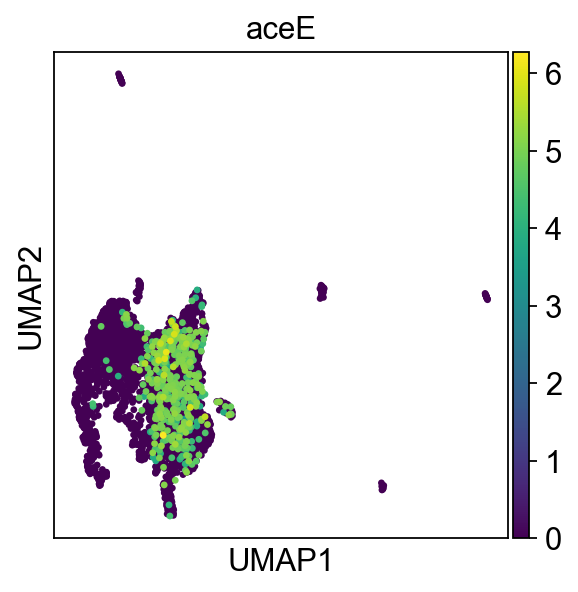

In [80]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=adata.uns['X0'][0])

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


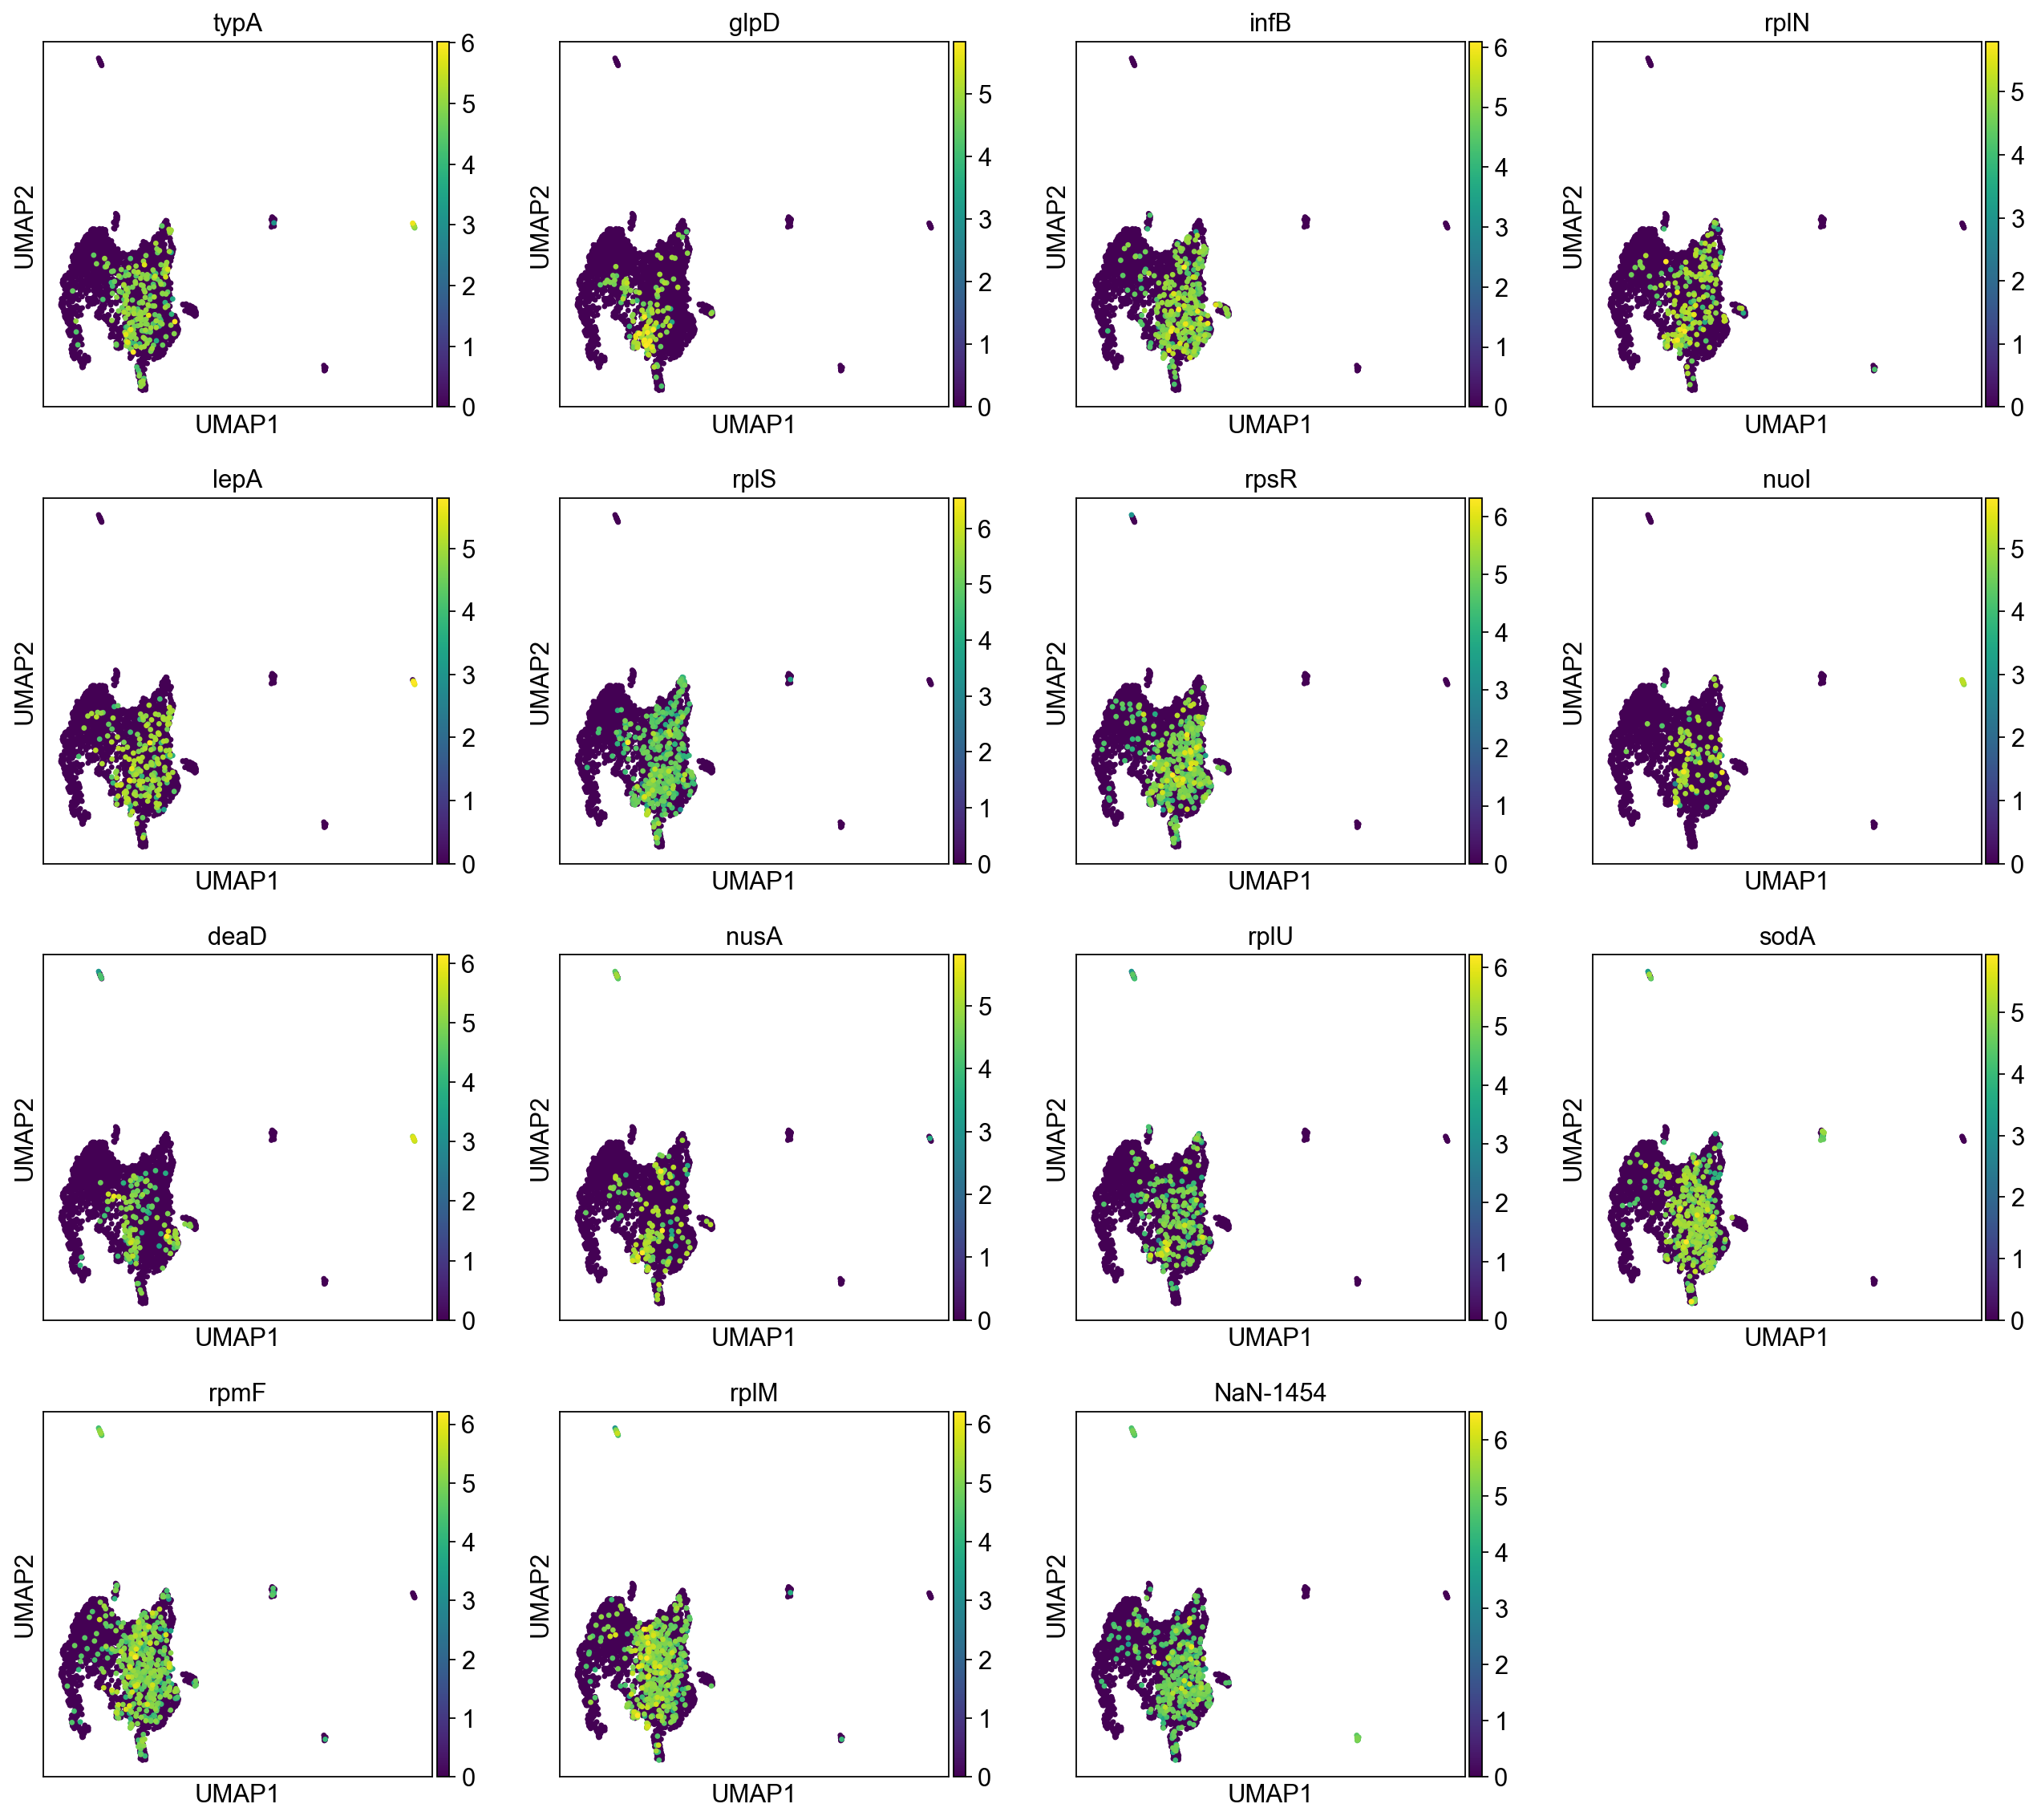

In [85]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=adata.uns['X3'])

### Part 2: Information metrics

We try out a few information metrics here

In [24]:
from scipy.spatial.distance import jensenshannon as JSD
from sklearn.metrics import mutual_info_score as MI

### Part 3: Comparing the clusters

We use MI to see the mutual information between different clusters and JSD to see how similar probability distributions are within the same cluster and in different clusters.

In [42]:
# JSD First
cluster_labels = adata.obs.leiden
JSD_metrics = np.zeros((adata.n_obs, 2))
for i in range(20):
    in_JSD = []
    out_JSD = []
    for j in range(adata.n_obs):
        if j != i:
            if cluster_labels[i] == cluster_labels[j]:
                in_JSD.append(JSD(adata.X[i, :], adata.X[j, :]))
            else:
                out_JSD.append(JSD(adata.X[i, :], adata.X[j, :]))
    JSD_metrics[i, 0] = np.average(in_JSD)
    JSD_metrics[i, 1] = np.average(out_JSD)
print(JSD_metrics)

[0.0020928195462329687, inf, 0.018313750940371933, inf, 0.026125589140068243, 0.004169151734205335, inf, inf, inf, 0.004169151734205335, 0.03377215584009156, 0.028051809438686157, inf, inf, 0.05594630796065981, inf, 0.05594630796065981, inf, 0.04866059172497385, inf, inf, inf, 0.03754076430862428, inf, inf, 0.022241827205658114, inf, 0.026125589140068243, inf, inf, inf, inf, inf, 0.018313750940371933, inf, inf, inf, inf, 0.010311943809319627, inf, inf, 0.031874741121951856, 0.018313750940371933, inf, 0.02028350692332338, inf, 0.04866059172497385, inf, 0.0, inf, inf, 0.04127654180364122, 0.04498225021395803, inf, inf, inf, 0.028051809438686157, 0.010311943809319627, inf, 0.05594630796065981, inf, inf, 0.026125589140068243, inf, 0.018313750940371933, inf, 0.0, inf, 0.016332226180003843, inf, inf, 0.004169151734205335, inf, 0.04866059172497385, inf, inf, inf, inf, 0.05594630796065981, 0.0020928195462329687, inf, 0.022241827205658114, inf, 0.05594630796065981, 0.04682468405976332, inf, 0.0

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

[0.0020928195462329687, inf, 0.01622301005472057, inf, 0.024036731666324408, 0.002077486197211071, inf, inf, inf, 0.002077486197211071, 0.0316859290363239, 0.025963548128518792, inf, inf, 0.0538720553724935, inf, 0.0538720553724935, inf, 0.04658156680629324, inf, inf, inf, 0.0354560792211422, inf, inf, 0.020151859618969387, inf, 0.024036731666324408, inf, inf, inf, inf, inf, 0.01622301005472057, inf, inf, inf, inf, 0.00822002116230903, inf, inf, 0.02978777776187987, 0.01622301005472057, inf, 0.018193169922745774, inf, 0.04658156680629324, inf, 0.0020928195462329687, inf, inf, 0.03919358016202983, 0.042901147147128824, inf, inf, inf, 0.025963548128518792, 0.00822002116230903, inf, 0.0538720553724935, inf, inf, 0.024036731666324408, inf, 0.01622301005472057, inf, 0.0020928195462329687, inf, 0.014241075224446547, inf, inf, 0.002077486197211071, inf, 0.04658156680629324, inf, inf, inf, inf, 0.0538720553724935, 0.0, inf, 0.020151859618969387, inf, 0.0538720553724935, 0.04474461089299254, in

[inf, inf, inf, inf, 0.007607605815464536, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 0.0024602653350862917, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 0.01884253100520726, inf, inf, inf, inf, 0.0024602653350862917, inf, inf, inf, inf, inf, inf, 0.002496029326435088, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 0.012902710362765697, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 0.007607605815464536, inf, 0.024289706136973708, 0.009648369389990512, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf

# Gene Set Enrichment Test
For each cluster, run a test on each signature & correct the p-values

In [18]:
# First we load in the relevant files
GCF_to_K0 = pd.read_csv('C:/Users/test/Documents/Smillie/scRNA-seq bacteria/GCF_000694555.kegg.txt', delimiter="\t")
pathway_names = pd.read_csv('C:/Users/test/Documents/Smillie/scRNA-seq bacteria/pathway_names.txt', delimiter="\t", names=['map', 'pathway'])
ko_to_path = pd.read_csv('C:/Users/test/Documents/Smillie/scRNA-seq bacteria/ko2path.txt', delimiter="\t", names=['K0', 'path'])
module_definitions = pd.read_csv('C:/Users/test/Documents/Smillie/scRNA-seq bacteria/module_definitions.txt', delimiter="\t", names=['M0', 'definition', 'K0'])
ko_to_module = pd.read_csv('C:/Users/test/Documents/Smillie/scRNA-seq bacteria/ko2module.txt', delimiter="\t", names=['K0', 'M0'])

In [51]:
# Define the Fisher test
from scipy.stats import fisher_exact
def FisherTest(gene_set1, gene_set2, gene_universe):
    plus_plus = len(list(set(gene_set1).intersection(gene_set2)))
    minus_plus = len(list(set(gene_set1) - set(gene_set2)))
    plus_minus = len(list(set(gene_set2) - set(gene_set1)))
    minus_minus = len(set(gene_universe) - set(gene_set1) - set(gene_set2))
    table = np.array([[plus_plus, plus_minus], [minus_plus, minus_minus]])
    oddsr, p = fisher_exact(table)
    return oddsr, p

In [57]:
# Build the relevant dataframe
fisher_pathway_df = pd.DataFrame(0.0, columns=np.arange(num_clusters), index=list(pathway_names['map']))

In [58]:
# Do the fisher test for all of the clusters and pathways
gene_universe = list(adata.raw.var.index)
pathway2g = {}
for i in range(num_clusters):
    print('running cluster ' + str(i))
    gs1 = adata.uns['X' + str(i)]
    for j in range(len(pathway_names)):
        pathway = pathway_names['map'][j]
        if pathway not in pathway2g.keys():
            gs2_pre = list(ko_to_path[ko_to_path['path'] == pathway]['K0'])
            gs2 = []
            for gid in gs2_pre:
                cds = list(GCF_to_K0[GCF_to_K0['ko'] == gid]['id'])
                for cd in cds:
                    gs2.append(gene_df[gene_df['id'] == cd]['gene'].item())
            pathway2g[pathway] = gs2
        # Do the fisher test
        gs2 = pathway2g[pathway]
        _, p = FisherTest(gs1, gs2, gene_universe)
        fisher_pathway_df[i][pathway] = p
fisher_pathway_df

running cluster 0
running cluster 1
running cluster 2
running cluster 3
running cluster 4
running cluster 5
running cluster 6
running cluster 7
running cluster 8
running cluster 9
running cluster 10
running cluster 11
running cluster 12
running cluster 13
running cluster 14


0         1         2    3         4    5    6    7       8   \
map00010  0.208015  0.021346  0.208015  1.0  1.000000  1.0  1.0  1.0  1.0000   
map00020  1.000000  1.000000  1.000000  1.0  0.138753  1.0  1.0  1.0  1.0000   
map00030  0.138600  1.000000  1.000000  1.0  1.000000  1.0  1.0  1.0  0.1386   
map00040  1.000000  1.000000  1.000000  1.0  1.000000  1.0  1.0  1.0  1.0000   
map00051  0.158458  1.000000  1.000000  1.0  1.000000  1.0  1.0  1.0  1.0000   
...            ...       ...       ...  ...       ...  ...  ...  ...     ...   
rn01200   1.000000  1.000000  1.000000  1.0  1.000000  1.0  1.0  1.0  1.0000   
rn01210   1.000000  1.000000  1.000000  1.0  1.000000  1.0  1.0  1.0  1.0000   
rn01212   1.000000  1.000000  1.000000  1.0  1.000000  1.0  1.0  1.0  1.0000   
rn01220   1.000000  1.000000  1.000000  1.0  1.000000  1.0  1.0  1.0  1.0000   
rn01230   1.000000  1.000000  1.000000  1.0  1.000000  1.0  1.0  1.0  1.0000   

           9    10        11   12   13   14  
map00010  1.0  1.0  0.208015  1.0  1.0  1.0  
map00020  1.0  1.0  0.138753  1.0  1.0  1.0  
map00030  1.0  1.0  0.138600  1.0  1.0  1.0  
map00040  1.0  1.0  1.000000  1.0  1.0  1.0  
map00051  1.0  1.0  1.000000  1.0  1.0  1.0  
...       ...  ...       ...  ...  ...  ...  
rn01200   1.0  1.0  1.000000  1.0  1.0  1.0  
rn01210   1.0  1.0  1.000000  1.0  1.0  1.0  
rn01212   1.0  1.0  1.000000  1.0  1.0  1.0  
rn01220   1.0  1.0  1.000000  1.0  1.0  1.0  
rn01230   1.0  1.0  1.000000  1.0  1.0  1.0  

[705 rows x 15 columns]

In [54]:
# Build the prefix to genes list
prefix2genes = {}
gene_list = gene_df.gene
for gene in list(gene_df.gene):
    if type(gene) == str:
        if len(gene) == 4:
            prefix = gene[0:3]
            if prefix in prefix2genes.keys():
                prefix2genes[prefix].append(gene)
            else:
                prefix2genes[prefix] = []
                
# Filter out the prefixes with less than 5 genes
prefix2genes_large = {}
for key in prefix2genes.keys():
    if len(prefix2genes[key]) >= 5:
        prefix2genes_large[key] = prefix2genes[key]

In [56]:
# Build the df for prefixes
fisher_prefix_df = pd.DataFrame(0.0, columns=np.arange(num_clusters), index=prefix2genes_large.keys())

In [62]:
# And now Fisher test on the prefixes
gene_universe = list(adata.raw.var.index)
for i in range(num_clusters):
    print('running cluster ' + str(i))
    gs1 = adata.uns['X' + str(i)]
    for j in range(len(prefix2genes_large.keys())):
        prefix = list(prefix2genes_large.keys())[j]
        gs2 = prefix2genes_large[prefix]
        _, p = FisherTest(gs1, gs2, gene_universe)
        fisher_prefix_df[i][prefix] = p
fisher_prefix_df

running cluster 0
running cluster 1
running cluster 2
running cluster 3
running cluster 4
running cluster 5
running cluster 6
running cluster 7
running cluster 8
running cluster 9
running cluster 10
running cluster 11
running cluster 12
running cluster 13
running cluster 14


0    1         2    3    4    5    6    7    8    9    10        11  \
cyd  1.0  1.0  1.000000  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000   
lpx  1.0  1.0  0.040834  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000   
leu  1.0  1.0  1.000000  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000   
ast  1.0  1.0  1.000000  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000   
nad  1.0  1.0  1.000000  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000   
..   ...  ...       ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
fec  1.0  1.0  1.000000  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.035098   
cit  1.0  1.0  1.000000  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000   
gsp  1.0  1.0  1.000000  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000   
rha  1.0  1.0  1.000000  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000   
pdu  1.0  1.0  1.000000  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000   

           12   13        14  
cyd  1.000000  1.0  1.000000  
lpx  1.000000  1.0  1.000000  
leu  1.000000  1.0  1.000000  
ast  0.023538  1.0  0.023538  
nad  1.000000  1.0  1.000000  
..        ...  ...       ...  
fec  1.000000  1.0  1.000000  
cit  1.000000  1.0  1.000000  
gsp  1.000000  1.0  1.000000  
rha  1.000000  1.0  1.000000  
pdu  1.000000  1.0  1.000000  

[85 rows x 15 columns]

In [122]:
from statsmodels.stats.multitest import multipletests
# Do the p-value adjustment. Reshape the fisher_df into a vector and then unshape. Using bh correction
pvals = fisher_pathway_df.stack()
correct_ps = multipletests(pvals, method='fdr_bh', alpha=0.05)
correct_ps[1].min()

# And now on the prefixes
# pvals = fisher_prefix_df.stack()
# correct_ps

1.0